# Example of how to read and parse the data file save from the rogue software

In [48]:
# Setup the library
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
top_level=f'{os.getcwd()}/..'

# Waveforms variables to be filled
adcLive = { i : []  for i in range(4) }
ampLive = { i : []  for i in range(4) }  
adcFault = { i : []  for i in range(4) }
ampFault = { i : []  for i in range(4) }  

# Open the .dat file
with fileio.FileReader(files=f'{top_level}/data/data_20231023_afterbpf_zcu111.dat') as fd:
    
    # Loop through the file data
    for header,data in fd.records():

        # Convert the numpy array to 16-bit values
        rawData = data[16:].view(np.int16)
        
        # Check for error in frame
        if (header.error>0):
            # Look at record header data
            print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
            print(f"Record size    = {header.size}")
            print(f"Record channel = {header.channel}")
            print(f"Record flags   = {header.flags:#x}")
            print(f"Record error   = {header.error:#x}")

        # Check if ADC Live waveform
        elif header.channel < 4:
            adcLive[header.channel-0].append(rawData)

        # Check if AMP Live waveform
        elif header.channel < 8:
            ampLive[header.channel-4].append(rawData)        

        # Check if ADC Live waveform
        elif header.channel < 12:
            adcFault[header.channel-8].append(rawData)

        # Check if AMP Live waveform
        elif header.channel < 16:
            ampFault[header.channel-12].append(rawData)  
        
        # Else undefined stream index
        else:
            print('UNDEFINED DATA STREAM!!!')

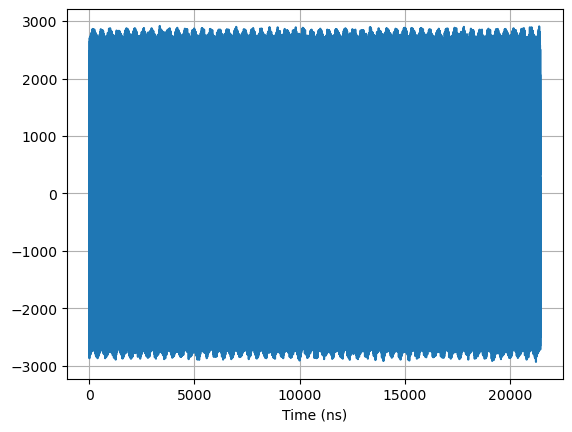

In [92]:
# Plot a waveform from AMP[3]
size = len(adcFault[2][55])
timeBin = 1.0/(0.509*6.0) # Unit of ns for 3.054 GSPS
timeSteps = np.linspace(0, timeBin*(size-1), num=size)

# Plot the Waveform Full Scale
plt.plot(timeSteps,adcFault[2][9])
plt.xlabel("Time (ns)")
plt.grid()

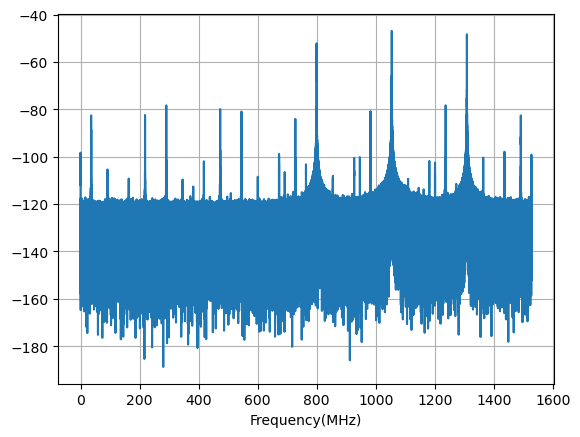

In [91]:
#FFT
size    = len(np.concatenate(adcFault[2]))# Number of data points in the file
timeBin = 1000/3054 # Unit of ns
freqBin = (0.5E+3/timeBin)/float(size//2) # Units of MHz
freqSteps = np.linspace(0, freqBin*(size//2-1), num=size//2)
freq = np.fft.fft(np.concatenate(adcFault[2]))/float(size)
freq = freq[range(size//2)]
mag = 20.0*np.log10(np.abs(freq)/32767.0) # Units of dBFS

plt.plot(freqSteps,mag)
plt.xlabel("Frequency(MHz)")

plt.grid()
plt.show()

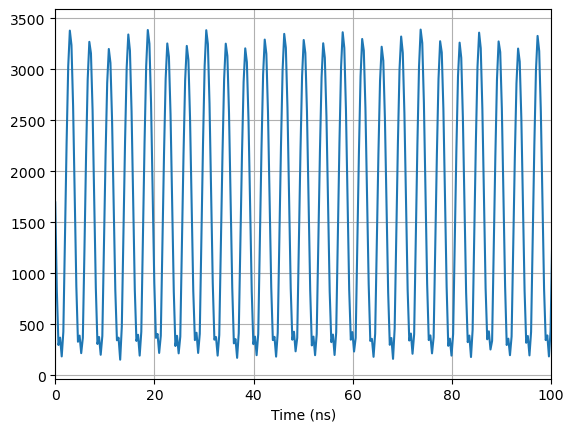

In [49]:
#plt.figure(figsize=(14,5))
plt.plot(timeSteps,ampFault[3][1])
plt.xlabel("Time (ns)")
plt.xlim(0,100)
plt.grid()

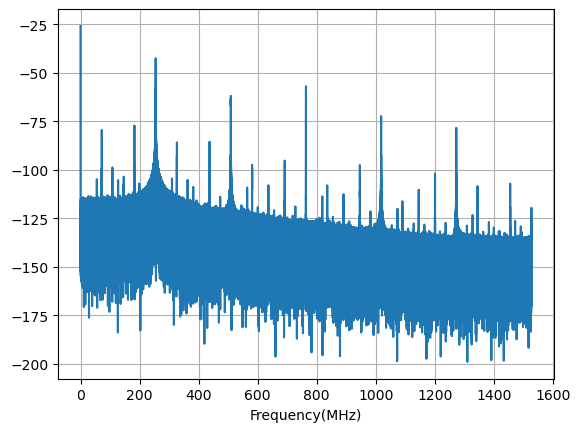

In [90]:
#FFT
size    = len(np.concatenate(ampFault[2]))# Number of data points in the file
timeBin = 1000/3054 # Unit of ns
freqBin = (0.5E+3/timeBin)/float(size//2) # Units of MHz
freqSteps = np.linspace(0, freqBin*(size//2-1), num=size//2)
freq = np.fft.fft(np.concatenate(ampFault[2]))/float(size)
freq = freq[range(size//2)]
mag = 20.0*np.log10(np.abs(freq)/32767.0) # Units of dBFS

plt.plot(freqSteps,mag)
plt.xlabel("Frequency(MHz)")

plt.grid()
plt.show()

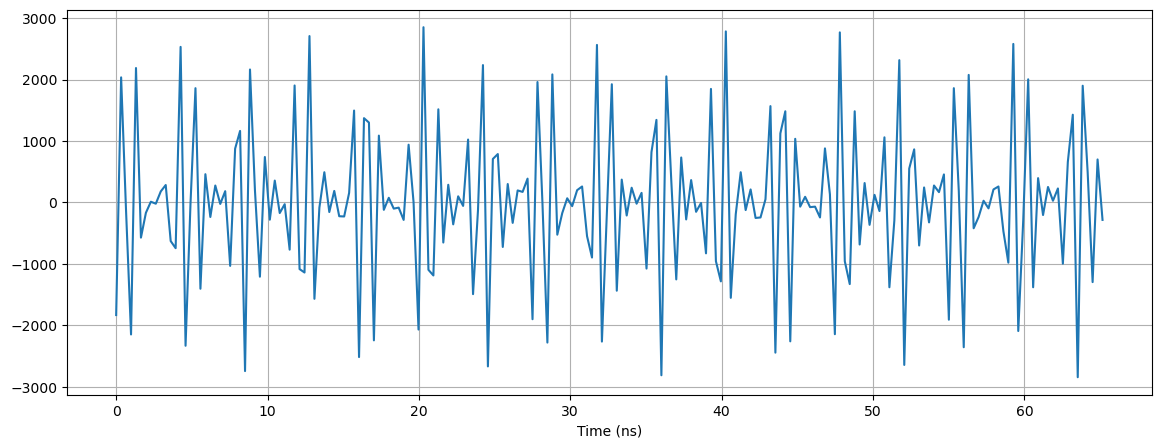

In [39]:
plt.figure(figsize=(14,5))
plt.plot(timeSteps[0:200],adcLive[3][1][0:200])
plt.xlabel("Time (ns)")
plt.grid()

In [43]:
#search peak and sum
def peak_search(waveform_data):
    mountain_maxima = []
    peaksum = []
    
    data_length = len(waveform_data)
    
    noise_threshold = 3000  
    
    for i in range(1, data_length - 1):
        if waveform_data[i] > waveform_data[i - 1] and waveform_data[i] > waveform_data[i + 1]:
            candidate_peak = waveform_data[i]
            sum = waveform_data[i-3]+waveform_data[i-2]+waveform_data[i-1]+waveform_data[i]+waveform_data[i+1]+waveform_data[i+2]+waveform_data[i+3]
            
            if candidate_peak > noise_threshold:
                mountain_maxima.append(candidate_peak)
                peaksum.append(sum)
    return mountain_maxima,peaksum

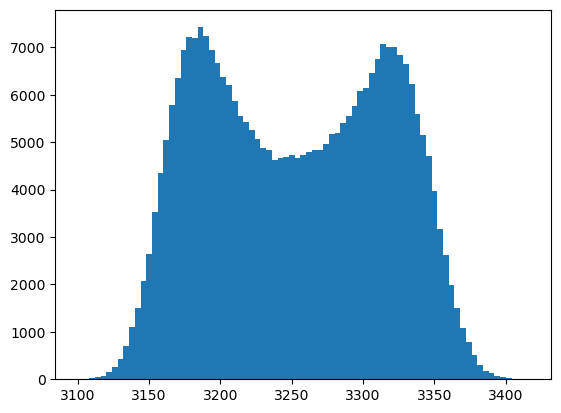

In [46]:
plt.hist(peak_search(np.concatenate(ampFault[2]))[0],bins=79)
plt.show()

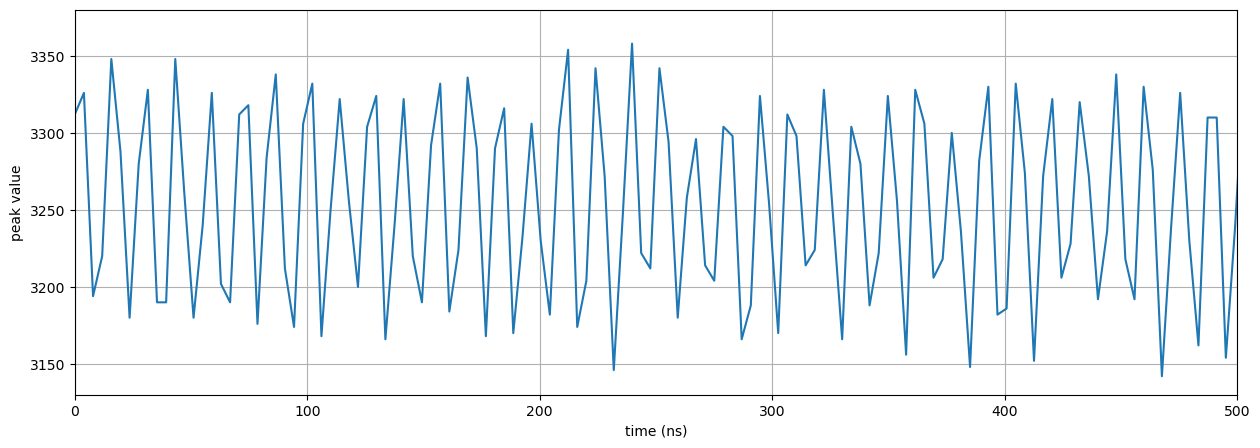

In [75]:
bunch_number=np.arange(0,len(peak_search(np.concatenate(ampFault[2]))[0]))*1000/254.5
plt.figure(figsize=(15,5))
plt.plot(bunch_number,peak_search(np.concatenate(ampFault[2]))[0])
plt.xlim(0,500)
plt.ylim(3130,3380)
plt.xlabel("time (ns)")
plt.ylabel("peak value")
plt.grid()
plt.show()

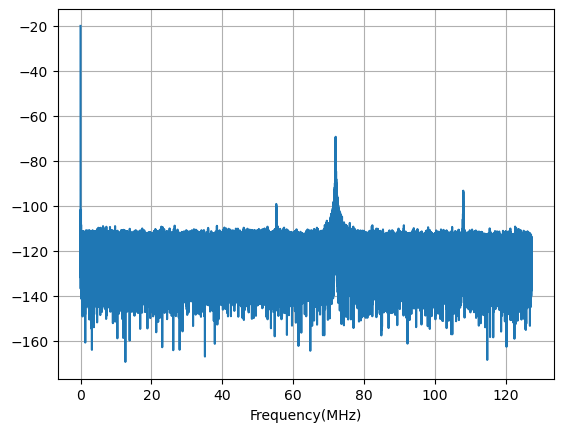

In [84]:
#FFT
size    = len(peak_search(np.concatenate(ampFault[2]))[0]) # Number of data points in the file
timeBin = 1000/254.5 # Unit of ns
freqBin = (0.5E+3/timeBin)/float(size//2) # Units of MHz
freqSteps = np.linspace(0, freqBin*(size//2-1), num=size//2)
freq = np.fft.fft(peak_search(np.concatenate(ampFault[2]))[0])/float(size)
freq = freq[range(size//2)]
mag = 20.0*np.log10(np.abs(freq)/32767.0) # Units of dBFS

plt.plot(freqSteps,mag)
plt.xlabel("Frequency(MHz)")
#plt.xlim(70,80)
plt.grid()
plt.show()

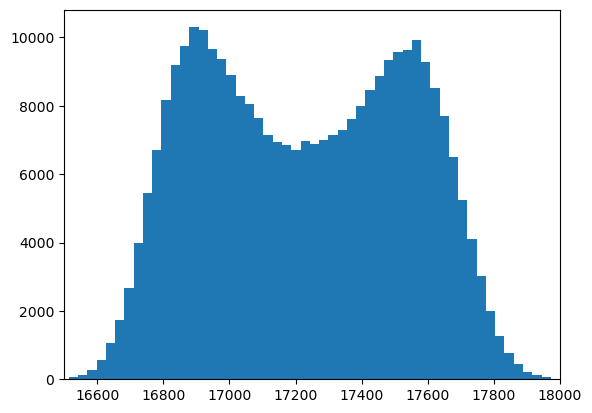

In [42]:
#hist of sum of 7 points around peak
plt.hist(peak_search(np.concatenate(ampFault[2]))[1],bins=200)
plt.xlim(16500,18000)
plt.show()